In [25]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import rice
from scipy.special import iv as Iv
from scipy.stats.mstats import gmean

import emcee
from multiprocessing import Pool

import time
import corner

from getdist import plots, MCSamples
import getdist

# import pymc3 as pm
# import arviz as az

# import dynesty

# import theano
# import theano.tensor as tt

# from theano.compile.ops import as_op

%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False
%matplotlib inline

In [3]:
import Loglikeli

In [4]:
fres = np.array([2.3, 5, 23, 28, 33]); nu0 = gmean(fres); nside = 32

In [6]:
total_P = np.load('/global/cscratch1/sd/jianyao/CBASS/Observations/homo_noise/totalP_s0_%s_uK_RJ_000.npy'%nside)#/1000 ## from uK to mK
total_sigma = np.load('/global/cscratch1/sd/jianyao/CBASS/Noise/homo_noise/5_fre_sigma_P_%s_uK_RJ.npy'%nside)#/1000 ## from uK to mK
P_nu0 = np.load('/global/cscratch1/sd/jianyao/CBASS/Foreground/P_nu0_s0_%s_uK_RJ.npy'%nside)#/1000

mask_both = np.load('/global/cscratch1/sd/jianyao/CBASS/mask_both_%s.npy'%nside)
mask_index = np.load('/global/cscratch1/sd/jianyao/CBASS/masked_index.npy')

In [154]:
P_nu0[5957]

1877.9288

In [142]:
frelist = [0,1,2,3,4]

logL = Loglikeli.logLike(nside, fres,frelist, total_P, total_sigma, 5957)

In [148]:
npara = 2; index = 0

def log_prior(theta):
    A0, beta = theta
    if 0 < A0 < 500 and -4 < beta < -2:
        return 0.0
    return -np.inf

def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logL.loglike(theta)

In [149]:
pos = np.array((100, -4)) + 1e-4 * np.random.randn(64, 2)
nwalkers, ndim = pos.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool)
    start = time.time()
    sampler.run_mcmc(pos, 500, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

100%|██████████| 500/500 [00:07<00:00, 70.95it/s]


Multiprocessing took 7.1 seconds


In [150]:
A0, beta = np.median(sampler.flatchain, axis = 0)

In [151]:
A0

191.4431348525502

In [152]:
beta

-3.031461248582425

In [111]:
np.mean(sampler.acceptance_fraction)

0.42614062500000005

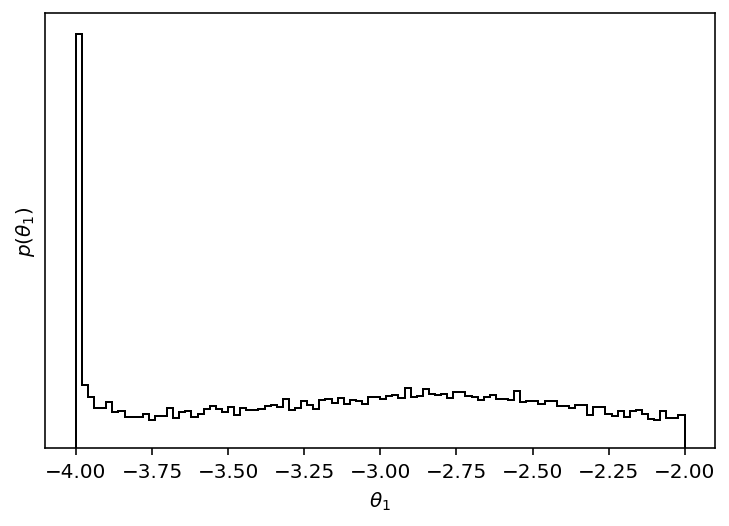

In [159]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 1], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

In [79]:
# tau = sampler.get_autocorr_time()
# print(tau)

In [88]:
flat_samples.shape

(32000, 2)

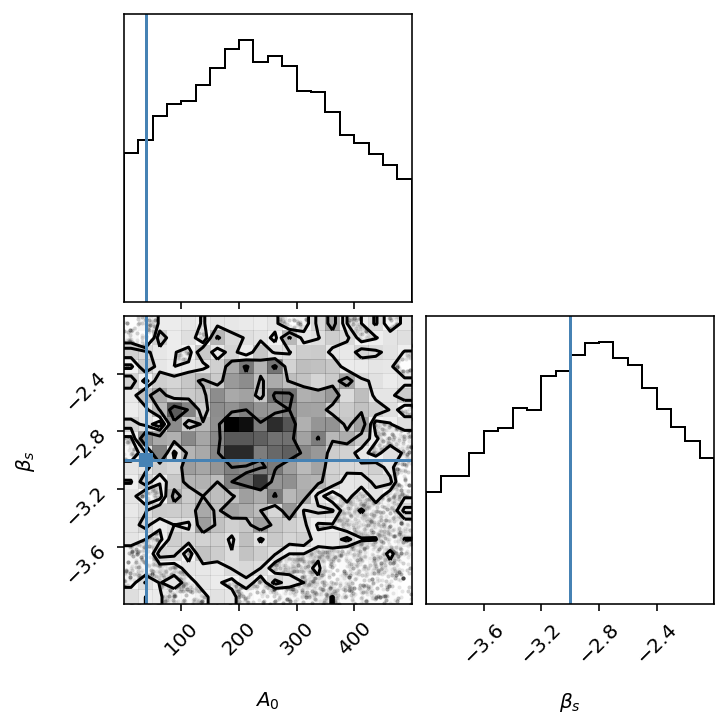

In [156]:
flat_samples = sampler.get_chain(discard=100, thin=1, flat=True)

labels = ['$A_0$', r'$\beta_s$']
fig = corner.corner(
    flat_samples, labels=labels, truths=[38,-3]
);

In [15]:
flat_samples.shape

(832, 2)

In [92]:
names = ['1', '2']
labels = ['A_0', 'beta_s']
samples = MCSamples(samples=flat_samples,names = names, labels = labels)
# samples2 = MCSamples(samples=flat_samples[:,1],names = names, labels = labels, label='Second set')

Removed no burn in


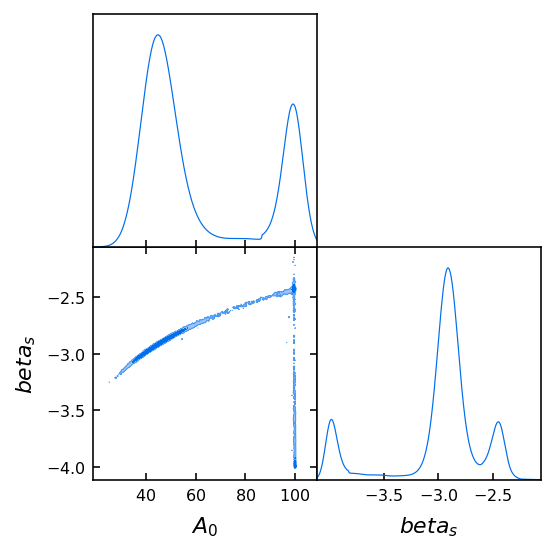

In [93]:
g = plots.get_subplot_plotter()
g.triangle_plot([samples], filled=True)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.05,0.1,-0.24,0.14,0.0,0.0,4109.22,5658.65,1.0


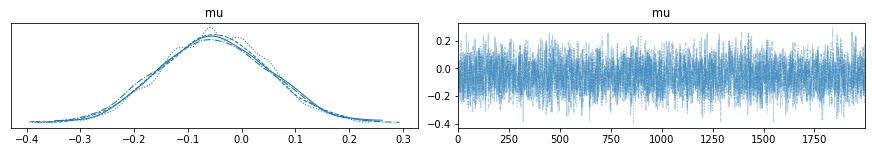

In [26]:
with model:
    az.plot_trace(idata)
    display(az.summary(idata, round_to=2))